# Entries

1. Historical statistics of direct confrontation (team 1 vs team 2)
2. Statistics of *N* previous matches for each team
3. Home player or away player
4. Current points on championship
5. Match day matters?

In [2]:
from pprint import pprint
from pymongo import MongoClient
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Opening MongoDB
MATCHES_COLLECTION_NAME = 'matches'
CLASSIFICATION_HISTORY_COLLECTION_NAME = 'rankings'
DB_NAME = 'soccer-prediction'

client = MongoClient()
db = client[DB_NAME]
matches_collection = db[MATCHES_COLLECTION_NAME]
classification_history = db[CLASSIFICATION_HISTORY_COLLECTION_NAME]

(array([3760., 3400., 1016., 2032., 2944., 3200., 2792., 1728., 1320.,
        1160.]),
 array([ 0. ,  3.1,  6.2,  9.3, 12.4, 15.5, 18.6, 21.7, 24.8, 27.9, 31. ]),
 <a list of 10 Patch objects>)

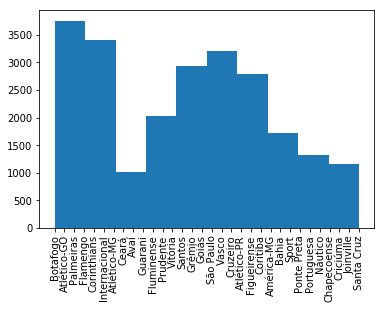

In [12]:
# Total number of matches per team
years = matches_collection.distinct('year')
freq = []
for year in years:
    year_teams = matches_collection.aggregate([{'$project':{'home_team':1}}])
    freq.extend([i['home_team'] for i in year_teams])

plt.xticks(rotation=90)
plt.hist(freq)

In [5]:
sample = matches_collection.find_one()
pprint(sample)

{'_id': ObjectId('5ac952926b5b9e2af46c59ef'),
 'arbiter': 'Leonardo Gaciba da Silva',
 'away_team': 'Santos',
 'cards': [{'player': 'Alex Sandro', 'team': 'SAN', 'type': 'yellow'},
           {'player': 'Zé Eduardo', 'team': 'SAN', 'type': 'yellow'},
           {'player': 'Herrera', 'team': 'BOT', 'type': 'yellow'},
           {'player': 'Wesley', 'team': 'SAN', 'type': 'yellow'},
           {'player': 'Alex Sandro', 'team': 'SAN', 'type': 'red'}],
 'coaches': {'away_team': 'Dorival Júnior', 'home_team': 'Joel Santana'},
 'home_team': 'Botafogo',
 'location': {'city': 'Brasil, Rio de Janeiro, RJ', 'stadium': 'Engenhão'},
 'players': {'away_team': [{'name': 'Felipe Garcia', 'position': 'GOL'},
                           {'name': 'Bruno Aguiar', 'position': 'ZAD'},
                           {'name': 'Durval', 'position': 'ZAE'},
                           {'name': 'Maranhão', 'position': 'LAD'},
                           {'name': 'Alex Sandro', 'position': 'LAE'},
                     

In [6]:
def extract_features(match):
#### Format [home_score, away_score, stats_goals_home_team, stats_goals_away_team, 
### stats_wins_home_team, stats_wins_away_team, stats_previous_draws, 
### *previous N matches home team (sg), *previous N matches away team (sg)]
    ##          ]
    N = 4
    stats = match['statistics']
    score = match['score']
    home_team_last_sg = get_last_N_sg(match['home_team'], N)
    away_team_last_sg = get_last_N_sg(match['away_team'], N)
    return [
            score['home_team'],
            score['away_team'], 
            stats['goals_home_team'], 
            stats['goals_away_team'],
            score['wins_home_team'], 
            stats['wins_away_team'], 
            stats['previous_draws'], 
            *home_team_last_sg, 
            *away_team_last_sg
           ]
    pass

In [11]:
def get_last_results(team, limit):
    query_constraints = {'$or':[ {'away_team':team}, {'home_team':team}]}
    query_projections = {'home_team':1, 'away_team':1, 'year':1, 'round':1, 'score':1, 'teams': 1}
    query_sort_criteria = [('year',-1), ('round',-1)]

    matches = matches_collection.find(query_constraints, query_projections)\
                                .sort(query_sort_criteria)\
                                .limit(limit)
    sgs =[]
    for match in matches:
        score = match['score']
        is_home = team == match['home_team']
        
        if is_home:
            sg = score['home_team'] - score['away_team']
        else:
            sg = score['away_team'] - score['home_team']
        sgs.append(sg)
    
    return sgs

In [10]:
for i in get_last_results('Corinthians', 5):
    pprint(i)

0
0
1
-2
-1
